# LIBRAIRIES

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from skimage import measure
from matplotlib.pyplot import *
import numpy as np
import math
from IPython.display import Image
from glob import glob
import os
import mahotas as mt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

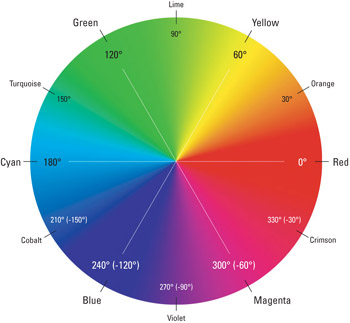

In [2]:
Image(filename='hsv.jpeg')

**Transformation de toutes les images en images jpg**

In [3]:
def transforme_img_to_jpg(path_file_src):
#entrer le path du fichier source sans / a la fin
    path=path_file_src+"/*.png"
    pngs = glob(path)

    for j in pngs:
        img = cv2.imread(j)
        cv2.imwrite(j[:-3] + 'jpg', img)
        os.remove(j)

    pngs = glob('img/*.jpeg')

    for j in pngs:
        img = cv2.imread(j)
        cv2.imwrite(j[:-4] + 'jpg', img)
        os.remove(j)

    pngs = glob('img/*.gif')

    for j in pngs:
        gif = cv2.VideoCapture(j)
        ret, frame = gif.read()
        cv2.imwrite(j[:-3] + 'jpg', frame)
        gif.release()
        cv2.destroyAllWindows()
        os.remove(j)
        
    return "Done"

**Extraction de la premiere feature**
* Associe la couleur principal de l'objet a chaque image

In [4]:
def principal_colour_object (path_image):
    #Nous retournerons les couleurs de manieres ordinal pour réaliser un KNN
    #0: jaune
    #1: rouge
    #2: orange
    #3: autres
    

    #chargement de l'image
    image =cv2.imread(path_image)

    #définition des constantes
    hauteur=image.shape[0]
    largeur=image.shape[1]
    couche=image.shape[2]
    
    
    #travaille de l'image en hsv car couleur bcp plus précise
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hue,sat,val = cv2.split(hsv)
    
    #Nous savons que nos fruit sont de différentes couleurs, nous allons donc determiné le poucentage 
    #de couleur present dans chaque fruit la couleur majoritaire sera la couleur du fruit
    
    ##CONSTANTE
    couleur=[]
    pixelcouleur=0
    pixeltotal=largeur*hauteur
    
    
    #on fait ce calcul 4 fois car nous avons 4 couleurs a determiner
    for i in range(4):
        if i==0:
        #calcul des pixels jaunes dans l'image
            lower = np.array([45/2],dtype=np.uint8)
            upper = np.array([60/2],dtype=np.uint8)
            #Image segmenté selon le tresshold de la couleur jaune
            seg_hue = cv2.inRange(hue,lower,upper)

            pixelcouleur=np.sum(seg_hue==255)
            pourcentage=(pixelcouleur*100)/pixeltotal
            #jaune premier pourcentage de ce tableau
            couleur.append(pourcentage)
        elif i==1:
        #calcul des pixels rouge dans l'image
            lower = np.array([0/2,50,0],dtype=np.uint8)
            upper = np.array([20/2,255,255],dtype=np.uint8)
            seg_hue1 = cv2.inRange(hsv,lower,upper)
            
            lower = np.array([330/2,180,0],dtype=np.uint8)
            upper = np.array([360/2,255,255],dtype=np.uint8)
            seg_hue2 = cv2.inRange(hsv,lower,upper)
            

            pixelcouleur1=np.sum(seg_hue1==255)
            pourcentage1=(pixelcouleur1*100)/pixeltotal
            
            
            pixelcouleur2=np.sum(seg_hue2==255)
            pourcentage2=(pixelcouleur2*100)/pixeltotal
            pourcentage=pourcentage1+pourcentage2
            
            
            #jaune premier pourcentage de ce tableau
            couleur.append(pourcentage)
        elif i==2:
            #calcul des pixels orange dans l'image
            lower = np.array([28/2],dtype=np.uint8)
            upper = np.array([40/2],dtype=np.uint8)
            #Image segmenté selon le tresshold de la couleur orange
            seg_hue = cv2.inRange(hue,lower,upper)

            pixelcouleur=np.sum(seg_hue==255)
            pourcentage=(pixelcouleur*100)/pixeltotal
            #jaune premier pourcentage de ce tableau
            couleur.append(pourcentage)
        elif i==3:
             
            lower = np.array([0,0,0],dtype=np.uint8)
            upper = np.array([114,150,90],dtype=np.uint8)
            seg_hue = cv2.inRange(hsv,lower,upper)
            pixelcouleur=np.sum(seg_hue==255)
            pourcentage=(pixelcouleur*100)/pixeltotal
            #jaune premier pourcentage de ce tableau
            couleur.append(pourcentage)
    
    
    
    #on retourne la couleur majoritaire
    couleur_nominal=couleur.index(max(couleur))
    couleur_classe=["jaune","rouge","orange","avocat"]

    #print(f"la couleur du fruit dans l'image est : {couleur_classe[couleur_nominal]} avec pour classe nominal :{couleur_nominal}")
    
    return couleur_nominal

**Extraction de 3 features de forme**
* Recupere la roundnes de la forme, k= si la forme est convex ou pas (plus un essai qu'une feature utile), aspect_ratio : creer une bounding box et fait le ratio hauteur largeur, peut etre plus utile que roundness

In [5]:
def calculate_feature_extraction(path_image):
    img=cv2.imread(path_image)
    no_fond=img.copy()
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,200,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    M = cv2.moments(cnt)
    #calculate area et perimeter
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
    if perimeter!=0:
         circularity= 4*area/(perimeter*perimeter)
    else:
        circularity="nan"
    #if is convexe    
    k = cv2.isContourConvex(cnt)
    if k==True:
        k=1
    else:
        k=0
    x,y,w,h= cv2.boundingRect(cnt)
    aspect_ratio=w/h
    
    hauteur=no_fond.shape[0]
    largeur=no_fond.shape[1]
    couche=no_fond.shape[2]
    
    
    for compteur1 in range(hauteur):
        for compteur2 in range(largeur):
            if thresh[compteur1][compteur2]!=0:
                for compteur3 in range(couche):
                    no_fond[compteur1][compteur2][compteur3]=0
    
    
    return(circularity,k,aspect_ratio,thresh,no_fond)

**Extraction de 13 features**
* Recupere 13 features de textures, peut etre utile pour certaine image ici nous en avons pas assé

In [6]:
def extract_features_Mahotas_haralik(image):
        # calculate haralick texture features for 4 types of adjacency
        textures = mt.features.haralick(image)

        # take the mean of it and return it
        ht_mean = textures.mean(axis=0)
        return ht_mean

In [7]:
def return_haralik_feature(path_image):
    image = cv2.imread(path_image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = extract_features_Mahotas_haralik(gray)
    
    return features

**Extraction de 1 features de texture**
* calcule la moyenne des valeur des pixexels hue sur une image detouré

In [8]:
def principal_hue_object (image_whith_no_fond):
  #on prend l'image detouré et on renvoi la moyenne de la saturation de l'image

    #chargement de l'image
    image =image_whith_no_fond
    
    #travaille de l'image en hsv car couleur bcp plus précise
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hue,sat,val = cv2.split(hsv)
    
    #définition des constantes
    hauteur=hue.shape[0]
    largeur=hue.shape[1]
    
    pixel_color=0
    compteur=0
    for i in range(hauteur):
        for j in range(largeur):
            if hue[i][j]!=0:
                pixel_color=pixel_color+1
                compteur=compteur+hue[i][j]
    
    mean_hue=compteur/pixel_color
    
    
    return mean_hue

**Extraction de 1 features de textures**
* calcule la moyenne des valeur des pixels saturation sur une image detouré

In [9]:
def principal_saturation_object (image_whith_no_fond):
  #on prend l'image detouré et on renvoi la moyenne de la saturation de l'image

    #chargement de l'image
    image =image_whith_no_fond
    
    #travaille de l'image en hsv car couleur bcp plus précise
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hue,sat,val = cv2.split(hsv)
    
    #définition des constantes
    hauteur=sat.shape[0]
    largeur=sat.shape[1]
    
    pixel_color=0
    compteur=0
    for i in range(hauteur):
        for j in range(largeur):
            if sat[i][j]!=0:
                pixel_color=pixel_color+1
                compteur=compteur+sat[i][j]
    
    mean_saturation=compteur/pixel_color
    
    
    return mean_saturation

**Extraction de 1 features de texture**
* calcule la moyenne des valeur des pixels values sur une image detouré

In [10]:
def principal_value_objet (image_whith_no_fond):
  #on prend l'image detouré et on renvoi la moyenne de la saturation de l'image

    #chargement de l'image
    image =image_whith_no_fond
    #travaille de l'image en hsv car couleur bcp plus précise
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hue,sat,val = cv2.split(hsv)
    
    #définition des constantes
    hauteur=val.shape[0]
    largeur=val.shape[1]
    
    pixel_color=0
    compteur=0
    for i in range(hauteur):
        for j in range(largeur):
            if val[i][j]!=0:
                pixel_color=pixel_color+1
                compteur=compteur+val[i][j]
    
    mean_val=compteur/pixel_color
    
    
    return mean_val

**Extraction de 1 features de textures**
* calcule la variance des valeur des pixels hue sur une image detouré

In [11]:
def std_h(image_whith_no_fond):
    
    #chargement de l'image
    image =image_whith_no_fond
    #travaille de l'image en hsv car couleur bcp plus précise
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hue,sat,val = cv2.split(hsv)
    
    #définition des constantes
    hauteur=hue.shape[0]
    largeur=hue.shape[1]
    
    pixel=[]
    for i in range(hauteur):
        for j in range(largeur):
            if hue[i][j]!=0:
                pixel.append(hue[i][j])
    pixel=np.array(pixel)
    std_hue=np.std(pixel)
    
    return std_hue

**Extraction de 1 features de texture**
* calcule la variance des valeur des pixels saturation sur une image detouré

In [12]:
def std_s(image_whith_no_fond):
    
    #chargement de l'image
    image =image_whith_no_fond
    #travaille de l'image en hsv car couleur bcp plus précise
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hue,sat,val = cv2.split(hsv)
    
    #définition des constantes
    hauteur=sat.shape[0]
    largeur=sat.shape[1]
    
    pixel=[]
    for i in range(hauteur):
        for j in range(largeur):
            if sat[i][j]!=0:
                pixel.append(sat[i][j])
    pixel=np.array(pixel)
    std_sat=np.std(pixel)
    
    return std_sat

**Extraction de 1 features de texture**
* calcule la variance des valeur des pixels value sur une image detouré

In [13]:
def std_v(image_whith_no_fond):
    
    #chargement de l'image
    image =image_whith_no_fond
    #travaille de l'image en hsv car couleur bcp plus précise
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hue,sat,val = cv2.split(hsv)
    
    #définition des constantes
    hauteur=val.shape[0]
    largeur=val.shape[1]
    
    pixel=[]
    for i in range(hauteur):
        for j in range(largeur):
            if val[i][j]!=0:
                pixel.append(val[i][j])
    pixel=np.array(pixel)
    std_val=np.std(pixel)
    
    return std_val

**Extraction de 1 features de forme**
* calcule l'elongation de la forme

In [14]:
def elongation(m):
    x = m['mu20'] + m['mu02']
    y = 4 * m['mu11']**2 + (m['mu20'] - m['mu02'])**2
    return (x + y**0.5) / (x - y**0.5)

In [15]:
def return_elongation(path_image):
    img = cv2.cvtColor(cv2.imread(path_image), cv2.COLOR_BGR2GRAY)
    img = 255 - cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)[1]
    m = cv2.moments(img)
    result = elongation(m)
    
    return result

**Retourne toute les features dans 2 list**

    *Liste 1 avec toutes les features sans les 13 haralik qui sont deja dans une liste
    *Liste 2 avec les 13 haralik features

In [16]:
def all_feature_for_image(path_image):
    color=principal_colour_object (path_image)
    circularity_feature,convex_feature,aspect_ratio_feature,thresh_image,no_fond_image=calculate_feature_extraction(path_image)
    haralik_feature=return_haralik_feature(path_image)
    hue_mean=principal_hue_object(no_fond_image)
    saturation_mean=principal_saturation_object(no_fond_image)
    values_mean=principal_value_objet (no_fond_image)
    std_hue=std_h(no_fond_image)
    std_sat=std_s(no_fond_image)
    std_val=std_v(no_fond_image)
    elongation=return_elongation(path_image)
    
    
    
    feature=[]
    feature.append(color)
    feature.append(circularity_feature)
    feature.append(convex_feature)
    feature.append(aspect_ratio_feature)
    feature.append(hue_mean)
    feature.append(saturation_mean)
    feature.append(values_mean)
    feature.append(std_hue)
    feature.append(std_sat)
    feature.append(std_val)
    feature.append(elongation)
    
    return feature,haralik_feature

**Transforme les deux list en deux df et les concatene**

* ON entre un path et on recupere un df avec toute les features extraite

In [17]:
def return_data_frame_for_image(path_image):
    tab1,tab2=all_feature_for_image(path_image)
    tab1=np.array(tab1)
    tab2=np.array(tab2)
    tab1=np.resize(tab1,(1,11))
    tab2=np.resize(tab2,(1,13))
    
    df_tab1=pd.DataFrame(data=tab1,columns=["color","Circularity_ratio","convex_boolean","ratio_bounding_box","mean_hue","mean_saturation","mean_values","std_hue","std_sat","std_val","elongation"])
    df_tab2=pd.DataFrame(data=tab2,columns=["haralik_feature1","haralik_feature2","haralik_feature3","haralik_feature4","haralik_feature5","haralik_feature6","haralik_feature7","haralik_feature8","haralik_feature9","haralik_feature10","haralik_feature11","haralik_feature12","haralik_feature13"])
    
    
    df_image=pd.concat([df_tab1,df_tab2],axis=1)
    
    return df_image

**Part du fichier et recupere tout les noms et créer un dataframe avec pour chaque image toute les features extraite**

In [20]:
path_file_src="/Users/edouardnadaud/Desktop/Analyse_dImage/TP_Imagerie_numerique_4A/img"

In [21]:
def create_dataframe_all_feature(path_file_src):
    transforme_img_to_jpg(path_file_src)
    path=path_file_src+"/*.jpg"
    image_name = glob(path)
    df=pd.DataFrame()
    
   
    for name in image_name:
        df_row=return_data_frame_for_image(name)
        df=pd.concat([df,df_row],axis=0)
  
    return df

In [22]:
df_feature=create_dataframe_all_feature(path_file_src)

**Recupere le nom des fichier et cree un tab de label**

In [23]:
def label_image(path_file_src):
    
    path=path_file_src+"/*.jpg"
    image_name = glob(path)
    label=[]
    for name in image_name:
        name=os.path.basename(name)
        name1=name.split("_", 1)
        label.append(name1[0])
    
    df_label=pd.DataFrame(data=label,columns=['label'])
    return df_label

In [24]:
df_label=label_image(path_file_src)

le df avec toutess les features etant mal indexe on reindexe les lignes avant de concatene les label pour voir nos best features

In [26]:
#concatenation
dataset1=df_feature
dataset1=dataset1.reset_index()
dataset1['label']=df_label

In [27]:
colors = {
    'avocat':'black', 
    'banane':'yellow', 
    'citron':'lime',
    'fraise':'red',
    'tomate':'pink',
    'orange':'orange'} 

In [28]:
#tests des best features

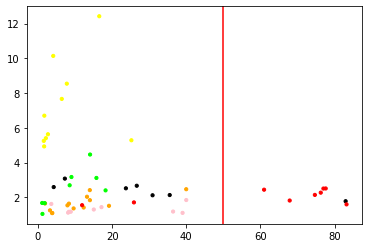

In [32]:
plt.scatter(dataset1['std_hue'],dataset1['elongation'], c=dataset1['label'].apply(lambda x: colors[x]), s=10)
plt.axvline(x=50,color="red")

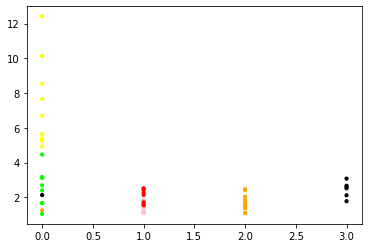

In [33]:
plt.scatter(dataset1['color'],dataset1['elongation'], c=dataset1['label'].apply(lambda x: colors[x]), s=10)

In [35]:
#Nous voyons que std_hue separre bien les fraise des tomate nous mettons donc une limite et nommons en ordinal

In [37]:
for i in range(len(dataset1['std_hue'])):
    dataset1['std_hue'][i]=float(dataset1['std_hue'][i])

<ipython-input-37-7abdc142ab6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1['std_hue'][i]=float(dataset1['std_hue'][i])


certaines valeures sont des str on remetsss tout en float

In [39]:
for i in range(len(dataset1['std_hue'])):
    if dataset1['std_hue'][i]>50:
        dataset1['std_hue'][i]=1
    else:
        dataset1['std_hue'][i]=0

<ipython-input-39-1b86e14ff42c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1['std_hue'][i]=0


In [41]:
#best  feature:= elongation color et std_hue
X=dataset1.iloc[:,[1,8,11]]
y=df_label

In [42]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
X = standardScaler.fit_transform(X)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
classifier = KNeighborsClassifier(n_neighbors=4)
classifier.fit(X_train, y_train)

/Users/edouardnadaud/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=4)

In [44]:
y_pred = classifier.predict(X_test)
classifier.score(X_test,y_test)

0.9473684210526315

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3 0 1 0 0 0]
 [0 2 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 4 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 2]]
              precision    recall  f1-score   support

      avocat       1.00      0.75      0.86         4
      banane       1.00      1.00      1.00         2
      citron       0.80      1.00      0.89         4
      fraise       1.00      1.00      1.00         4
      orange       1.00      1.00      1.00         3
      tomate       1.00      1.00      1.00         2

    accuracy                           0.95        19
   macro avg       0.97      0.96      0.96        19
weighted avg       0.96      0.95      0.95        19

